In [1]:
from fastai.vision.all import *
from facenet_pytorch import MTCNN
from torchvision.transforms.functional import to_pil_image
import pandas as pd
from PIL import Image

/home/norby/Coding/Racial-Recognition/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test']) 

In [3]:
mtcnn = MTCNN(
    image_size=224,
    margin=20,
    keep_all=True,
    post_process=True,
    select_largest=False,
    thresholds=[0.6, 0.7, 0.7]  
)

def detect_face_mtcnn(image_path):
    img = Image.open(image_path).convert('RGB')
    faces, _ = mtcnn.detect(img)
    
    if faces is None:
        return img 

    face_images = []
    for (x1, y1, x2, y2) in faces:
        face = img.crop((x1, y1, x2, y2))
        face_images.append(face)
    
    return face_images[0] if face_images else img

def get_face_image(row):
    image_path = './Dataset/' + row['file']
    return detect_face_mtcnn(image_path)

In [4]:
fairface_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  
    get_x=get_face_image,                       
    get_y=ColReader(['age', 'gender', 'race']), 
    splitter=RandomSplitter(seed=42),           
    item_tfms=Resize(224),                      
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
        *aug_transforms(
            size=224,
            max_rotate=10,
            min_scale=0.75,
            flip_vert=True,
            max_lighting=0.1,
            max_warp=0.0,
            p_affine=0.75,
            p_lighting=0.75
        )
            
    ] 
)

dls = fairface_block.dataloaders(train_df, bs=64)

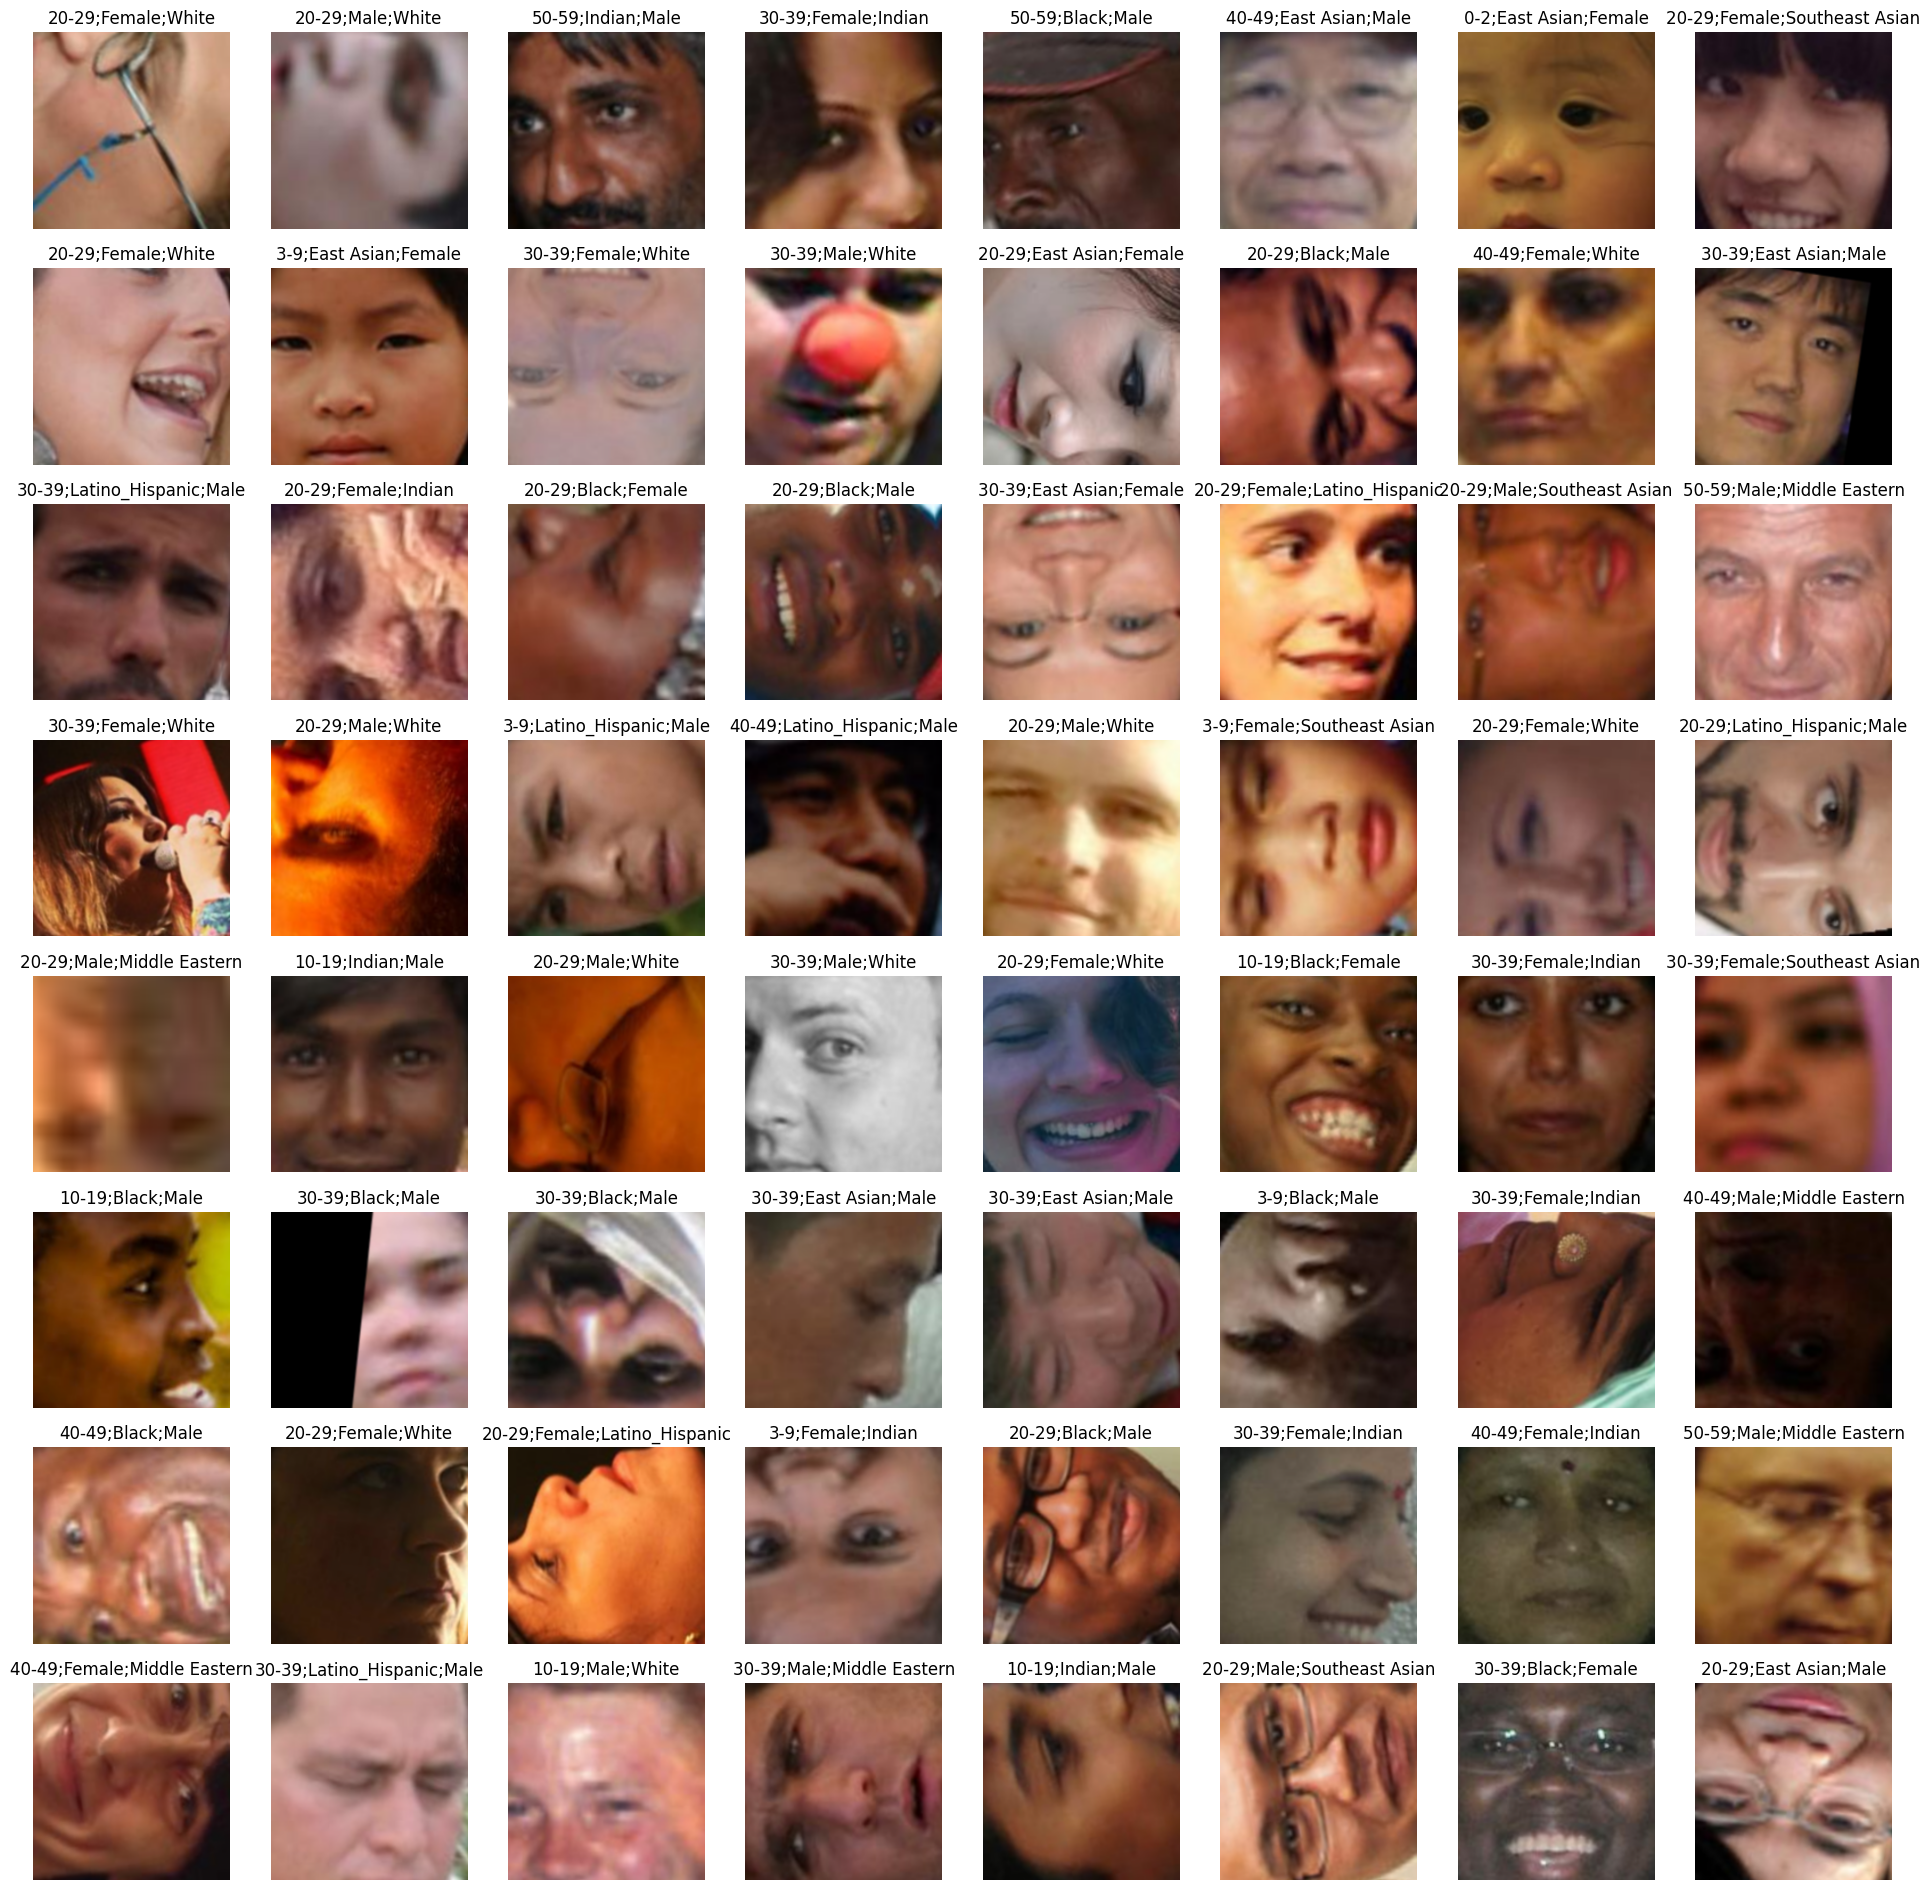

In [5]:
dls.show_batch(
    max_n=116
)